# Predict the topic of a Math Question on Math Education Resources

We will use **Machine Learning** to predict the topic of a Math Question from the [Math Education Resources](http://math-education-resources.com). For simplicity we will only consider two topics. Using [multiclass classification](https://en.wikipedia.org/wiki/Multiclass_classification) this can be extended to more than two topics (at the time of writing, April 2015, we have about 1500 questions with 150 topics on MER).

To Do:

1. ~~Fix pca - Alex~~
1. get feature importance
~~1. Write convenience functions:~~
  ~~1. text -> topic~~
  ~~2. text -> list of most similar questions (k-nn / cosine dist)  - Alex~~
1. Add the suggested topics to the database for questions w/o a topic
1. ~~Re-write train test split to:  - Alex~~
      1. Make sure that each topic appears at least once in train AND test (otherwise label_binarizer will remove that column, which leads to problems later in roc)
      2. make the code look good / account for errors - Alex
1. ~~ROC curve - fix for unbalanced data - Alex~~
1. ~~Put classifier predictions on the website - Alex~~
1. ~~Edit functions to work for both regular and parent topics - Bernhard~~
1. Normalize feature vectors - TF-IDF
1. Edit website

-----------------------
For later:
7. Add additional features (course, etc.)
    1. graph them
8. Put up recommendations on the website

In [1]:
import os
import json
import numpy as np
import helpers
from pymongo import MongoClient
import matplotlib.pyplot as plt
%matplotlib inline
try:
    import cPickle as pickle
except:
    import pickle


# machine learning modules
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# create an array of all topics of interest
topic_tags = ["Eigenvalues_and_eigenvectors",
              "Probability_density_function",
              "Taylor_series",
              "Substitution",
              "Lagrange_interpolation"]


questions_raw = helpers.get_questions_with_topics(topic_tags)

print('TOTAL:\n## - Topic\n==========')
for topic, count in helpers.count_topics_in_questions(questions_raw).iteritems():
    print('%2d - %s' %(count, topic.replace('_', ' ')))

TOTAL:
## - Topic
 2 - Linear approximation
 3 - Power iteration
 1 - Alternating series test
 1 - Condition number
 2 - Implicit differentiation
 5 - Matrix diagonalization
 1 - Determinants
 1 - Center of mass
 2 - Partial fractions
 1 - Matrix operations
45 - Eigenvalues and eigenvectors
 1 - Initial value problem
 2 - Random walks
37 - Substitution
 4 - Expected value and median
 4 - Trigonometric integral
 2 - Rank and nullity
 2 - Reflection
50 - Taylor series
 4 - Cumulative distribution function
 8 - Integration by parts
 1 - Matrix similarity
 2 - Fundamental theorem of calculus
 1 - Linear transformation definition
 2 - Lagrange interpolation
39 - Probability density function


In [3]:
client = MongoClient()
questions_collection = client['merdb'].questions
topics_collection = client['merdb'].topics

topic_to_parent_dict = helpers.get_topic_to_parent_dict()

print(helpers.questions_to_parents(questions_raw))
print('-' * 30)
print(helpers.unique_parents(questions_raw))

[[u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Linear_algebra'], [u'Sequences_and_series'], [u'Integrate'], [u'Integrate'], [u'Integrate'], [u'Sequences_and_series'], [u'Sequences_and_series'], [u'Integrate'], [u'Sequences_and_series'], [u'Integrate'], [u'Probability_and_statistics'], [u'Sequences_and_series'], [u'Integrate'], [u'Sequences_and_series'], [u'Integrate'], [u'Sequences_and_series'], [u'Probability_and_statistics'], [u

### Split into train and test set

In [4]:
def question_indices_by_topic(qs, parents=False):
    '''
    Returns list of the same length as the number of topics (parent topics if parents=True).
    Each list contains the indices of the questions qs in this topic (parent topic if parents=True)
    '''
    if parents:
        list_to_match = helpers.unique_parents(qs)
    else:
        list_to_match = topic_tags

    num_sublists = len(list_to_match)
    all_indices = [[] for i in range(num_sublists)]
    
    for i, q in enumerate(qs):
        for j, t in enumerate(list_to_match):
            if (not parents) and (t in q['topics']):
                all_indices[j].append(i)
            elif parents and t in helpers.question_to_parents(q):
                all_indices[j].append(i)
    return all_indices
                

for i, topic in enumerate(topic_tags):
    print "Question indices for topic %s: \n" % topic, question_indices_by_topic(questions_raw)[i]
    print "-" * 30
    
for i, topic in enumerate(helpers.unique_parents(questions_raw)):
    print "Question indices for topic %s: \n" % topic, question_indices_by_topic(questions_raw, parents=True)[i]
    print "+" * 30
    

Question indices for topic Eigenvalues_and_eigenvectors: 
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171]
------------------------------
Question indices for topic Probability_density_function: 
[39, 45, 49, 60, 61, 62, 63, 64, 67, 68, 72, 73, 77, 79, 83, 85, 87, 89, 93, 95, 97, 98, 100, 101, 103, 107, 108, 111, 112, 115, 116, 117, 118, 121, 123, 127, 129, 134, 137]
------------------------------
Question indices for topic Taylor_series: 
[30, 34, 35, 37, 40, 42, 44, 48, 53, 56, 59, 66, 69, 75, 76, 81, 82, 86, 88, 92, 94, 99, 106, 110, 113, 122, 124, 125, 128, 130, 132, 133, 135, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
------------------------------
Question indices for topic Substitution: 
[31, 32, 33, 36, 38, 41, 43, 46, 47, 50, 51, 52, 54, 55, 57, 58, 65, 70, 71, 72, 74, 78, 80, 84, 90, 91, 96, 102,

In [5]:
# for reproducibility we set the seed of the random number generator
np.random.seed(23)

def pick_random_index_per_topic(qs, parents=False):
    '''Returns a list of randomly chosen question indices - one for each topic (parent topic if parents=True)'''
    question_indices = question_indices_by_topic(qs, parents)
    result = []
    for indices in question_indices:
        # pick random index
        question_index_for_topic = np.random.choice(indices)
        # add to result list, avoiding duplicates in case questions match more than one topic (parent topic if parents=True)
        if question_index_for_topic not in result:
            result.append(question_index_for_topic)
    return result

print "Questions picked topics:", pick_random_index_per_topic(questions_raw)
print "Questions picked parents:", pick_random_index_per_topic(questions_raw, parents=True)

Questions picked topics: [21, 137, 145, 50, 0]
Questions picked parents: [74, 109, 170, 77, 125]


In [6]:
def remove_from_question_indices(ls, indices_by_topic):
    '''Takes a list ls and a list of lists indices_by_topic
        and removes all elements of ls from each element of indices_by_topic'''
    
    for index_list in indices_by_topic:
        for element in ls:
            if element in index_list:
                index_list.remove(element)
    
    return indices_by_topic

#example
print(remove_from_question_indices([1, 2, 3], [[1, 2, 4],[4, 3],[],[5]]))

[[4], [4], [], [5]]


In [7]:
# helper functions for the train_test_split function

def sample_from_class(indices, n):
    return np.random.choice(indices, n, replace = False)

def sample_from_all_classes(indices_by_topic, num_total_samples, num_questions):
    if (num_total_samples <= 0):
        return []

    sample_indices = set([])
    for index_list in indices_by_topic:
        if 0 == len(index_list):
            # it is possible that all samples from a particular class are 
            continue
        class_proportion = float(len(index_list)) / num_questions
        num_class_samples = int(num_total_samples * class_proportion)
        class_samples = sample_from_class(index_list, num_class_samples)
        # update the set sample_indices with new class samples
        sample_indices.update(class_samples)
    return list(sample_indices)

In [8]:
#np.random.seed(23)  #Set seed back to 23 to see the problem when a topic has no question in test set
np.random.seed(22)

def train_test_split(qs, TRAIN_PROPORTION=0.75, parents=False):
    '''randomly splits list of questions into two lists for train and test'''
    TRAIN_SIZE = int(TRAIN_PROPORTION * len(qs))
                        
    # pick a question from each topic (parent topic if parents=True) and add to training set
    indices_from_each_topic = pick_random_index_per_topic(qs, parents)
    
    # from the rest of the questions, pick indices from each class according to topic probabilities:
    indices_left = remove_from_question_indices(indices_from_each_topic, question_indices_by_topic(qs, parents))
        
    samples_left_to_take = TRAIN_SIZE - len(indices_from_each_topic)
    
    randomly_picked_indices = sample_from_all_classes(indices_left, 
                                                      samples_left_to_take, 
                                                      len(qs) - len(indices_from_each_topic))
    
    train_indices = sorted(indices_from_each_topic + randomly_picked_indices)
    
   
    qs_train = [q for i, q in enumerate(qs) if i in train_indices]
    qs_test = [q for i, q in enumerate(qs) if not i in train_indices]
    
    #permuted = np.random.permutation(len(qs_train))
    #qs_train_permuted = [qs_train[i] for i in permuted]
    #!!!
    return qs_train, qs_test, train_indices

questions_train, questions_test, train_indices = train_test_split(questions_raw, parents=False)

print("Question indices for training set:")
print(train_indices)
print("\n")
assert (questions_train[train_indices.index(3)]['sols_raw'] == questions_raw[3]['sols_raw'])


print('TRAIN/TEST:\n##/## - Topic\n=============')
for t in topic_tags:
    print('%2d/%2d - %s' % (sum([1 for q in questions_train if t in q['topics']]),
                          sum([1 for q in questions_test if t in q['topics']]),
                          t.replace('_', ' ')))    


print('\n' * 5)

questions_train, questions_test, train_indices = train_test_split(questions_raw, parents=True)

print("Question indices for training set (parents):")
print(train_indices)
print("\n")

print('TRAIN/TEST:\n##/## - Topic (Parents)\n=============')
for t in helpers.unique_parents(questions_train):
    print('%2d/%2d - %s' % (sum([1 for q in questions_train if t in helpers.question_to_parents(q)]),
                          sum([1 for q in questions_test if t in helpers.question_to_parents(q)]),
                          t.replace('_', ' ')))    


Question indices for training set:
[0, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20, 22, 24, 25, 26, 28, 29, 30, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67, 68, 71, 73, 74, 75, 76, 78, 79, 80, 82, 83, 85, 87, 89, 90, 91, 92, 95, 96, 101, 102, 103, 107, 108, 110, 111, 112, 113, 114, 117, 118, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 137, 139, 140, 141, 142, 143, 144, 145, 146, 148, 150, 151, 152, 153, 154, 156, 158, 160, 161, 163, 165, 166, 167, 168, 170, 171]


TRAIN/TEST:
##/## - Topic
33/12 - Eigenvalues and eigenvectors
29/10 - Probability density function
37/13 - Taylor series
27/10 - Substitution
 1/ 1 - Lagrange interpolation






Question indices for training set (parents):
[1, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 18, 19, 20, 22, 24, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 60, 61

In [27]:
vectorizer = helpers.save_TfidfVectorizer(questions_train)

X_train = helpers.questions_to_X(questions_train)
X_test = helpers.questions_to_X(questions_test)
assert X_train.shape[0] == len(questions_train)

y_train = helpers.questions_to_y(questions_train, helpers.unique_parents(questions_train), parents=True)
y_test = helpers.questions_to_y(questions_test, helpers.unique_parents(questions_train), parents=True)
assert len(y_train) == len(questions_train)

#!!!
print(y_train)
train_labels = helpers.questions_to_topic_index(questions_train, helpers.unique_parents(questions_train))
test_labels = helpers.questions_to_topic_index(questions_test, helpers.unique_parents(questions_train))


[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.24964008]
 [ 0.          0.          0.         ...,  0.          0.          0.06369257]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 1

### The actual classifier

In [10]:
# SVC for now
classifier = OneVsRestClassifier(svm.SVC(kernel='linear',
                                         probability = True,
                                         random_state=np.random.RandomState(0))
 
                                )


trained_classifier = classifier.fit(X_train, y_train)
pickle.dump(trained_classifier, open("svc.bin", "wb"))

In [11]:
preds = trained_classifier.predict_proba(X_test)
predicted_classes = helpers.preds_to_topics(preds, helpers.unique_parents(questions_train))

print('\n'.join(predicted_classes))

Sequences_and_series
Linear_algebra
Linear_algebra
Linear_algebra
Linear_algebra
Linear_algebra
Linear_algebra
Linear_algebra
Linear_algebra
Sequences_and_series
Integrate
Integrate
Integrate
Sequences_and_series
Probability_and_statistics
Probability_and_statistics
Integrate
Integrate
Sequences_and_series
Integrate
Sequences_and_series
Probability_and_statistics
Sequences_and_series
Probability_and_statistics
Probability_and_statistics
Probability_and_statistics
Probability_and_statistics
Integrate
Sequences_and_series
Probability_and_statistics
Probability_and_statistics
Probability_and_statistics
Sequences_and_series
Probability_and_statistics
Integrate
Sequences_and_series
Sequences_and_series
Integrate
Sequences_and_series
Sequences_and_series
Sequences_and_series
Sequences_and_series
Linear_algebra
Linear_algebra


In [12]:
# To visualize the problem with auc when a topic has no question in test set
#from sklearn.metrics import roc_curve, auc
#print('these numbers should all be the same:', y_train.shape[1], y_test.shape[1], preds.shape[1])
#fpr = dict()
#tpr = dict()
#roc_auc = dict()
#for i in range(preds.shape[1]):
#    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
#    roc_auc[i] = auc(fpr[i], tpr[i])

In [13]:
print('%.5f combined micro AUC score.' %helpers.combined_roc_score(y_test, preds)[0])

/home/alexf/.local/lib/python2.7/site-packages/sklearn/metrics/ranking.py:496: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


IndexError: index 4 is out of bounds for axis 1 with size 4

## Visualize (todo)

In [20]:
pca = PCA(n_components=3)
pca.fit(X_train.toarray())
pca_X_train = pca.transform(X_train.toarray())
pca_X_test = pca.transform(X_test.toarray())
print('The first 3 principal components explain %.2f of the variance in the dataset.' % sum(pca.explained_variance_ratio_))

The first 3 principal components explain 0.18 of the variance in the dataset.


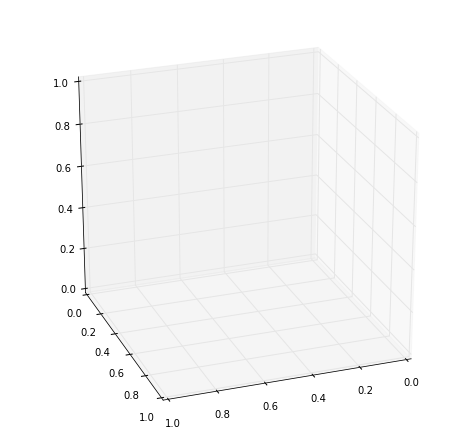

In [19]:
np.random.seed(23)
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .8, 1], elev=25, azim=70)

colors = [np.random.rand(3,1) for i in range(len(topic_tags))]

for i, l in zip(range(len(topic_tags)), train_labels):
    print(1)
    ax.scatter(pca_X_train[train_labels == i,0],
           pca_X_train[train_labels == i,1],
           pca_X_train[train_labels == i,2], c=colors[i], label = topic_tags[i] + ' (train)')
 
plt.legend()
plt.show()

In [ ]:
fig2 = plt.figure(1, figsize=(8, 6))
plt.clf()
ax2 = Axes3D(fig2, rect=[0, 0, .8, 1], elev=25, azim=70)
for i, l in zip(range(len(topic_tags)), test_labels):
    ax2.scatter(pca_X_train[test_labels == i,0],
           pca_X_train[test_labels == i,1],
           pca_X_train[test_labels == i,2], c=colors[i], label = topic_tags[i] + ' (test)', marker = 'x')   
 
plt.legend()
plt.show()

In [22]:
# Predicting using the entire dataset:

X = helpers.questions_to_X(questions_raw)
y = helpers.questions_to_y(questions_raw, topic_tags)

final_classifier = classifier.fit(X, y)

#!!!
pickle.dump(final_classifier, open("test_sending_json/final.bin", "wb"))

# Recommendations

In [105]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

def find_similar_indices(x, q_index, n, cosine=True):
    '''Returns an array of indices of n most similar questions in matrix,
       given the index q_index of the question in matrix'''
    if cosine:
        similarity_arr = 1-pairwise_distances(x, metric="cosine")
    else:
        similarity_arr = 1-pairwise_distances(x, metric="euclidean")
    sim = similarity_arr[q_index]
    top_n = sorted(range(len(sim)), key=lambda i: sim[i], reverse=True)[:(n+1)]
    top_n.remove(q_index)
    return top_n

def find_similar_qs(qs, q_index, n, cosine=True):
    x = helpers.questions_to_X(qs)
    if cosine:
        top_n = find_similar_indices(x, q_index, n)
    else:
        top_n = find_similar_indices(x, q_index, n, cosine=False)
    return [qs[i] for i in top_n]
    
    
print(find_similar_indices(X.toarray(), 0, 3))

print(questions_raw[0]['topics'])
print([q['topics'] for q in find_similar_qs(questions_raw, 0, 3)])

[1, 138, 149]
[u'Lagrange_interpolation']
[[u'Condition_number', u'Lagrange_interpolation'], [u'Implicit_differentiation', u'Taylor_series'], [u'Taylor_series']]
